<a href="https://colab.research.google.com/github/konan-91/OcularClassification/blob/master/notebooks/1_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generating Topoplots from Blinks

Our first step is to transform the dataset of ocular & non-ocular EEG data into spectograms (image files) that we can use to train the model.

In [ ]:
# Necessary if uploading file to colab to avoid file size limits
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install mne -q
!pip install pymatreader -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.7 MB/s eta 0:00:00


In [2]:
import mne
import pymatreader
import matplotlib.pyplot as plt
import numpy as np
import os

##Loading the data

Note: The dataset used for this notebook is large, and may overwhelm the RAM / CPU limits for Colab. I recommend downloading and running the notebook locally using Conda and Jupyter Labs. If using Colab, please ensure you have uploaded the dataset to your Google Drive. Else, ensure the zipped osf dataset is present at the root of your working directory. In Colab, this is /content.

In [ ]:
# If importing file from drive
extract_path = "/content/osfstorage"
if not os.path.exists(extract_path):
    os.mkdir(extract_path)

!unzip -q /content/drive/MyDrive/diss/osfstorage-archive.zip -d /content/osfstorage-archive

In [6]:
# If uploading file to workspace
extract_path = "/content/osfstorage"
if not os.path.exists(extract_path):
    os.mkdir(extract_path)

!unzip -q /content/osfstorage-archive.zip
!rm /content/osfstorage-archive.zip

In [73]:
def load_data(folderpath, data):
    for filename in os.listdir(folderpath):
        if filename.endswith(".set"):
            filepath = os.path.join(folderpath, filename)
            epochs = mne.read_epochs_eeglab(filepath) # The dataset we use comes pre-epoched
            data.append(epochs)

In [ ]:
mne.set_log_level()
path = "/content/osfstorage-archive"
participantsData = []

for study in os.listdir(path):
    study_path = os.path.join(path, study)
    if os.path.isdir(study_path):
        load_data(study_path, participantsData)

###Understanding the Dataset

Participants were asked to rest, blink, and make horizontal and vertical eye movements. As such, the dataset contains labelled and timestamped data of when each event occured. Labelled data is ideal for training classification models, as we can teach the model to discriminate between each event.

The OSF training dataset is split into 5 studies. Each study contains EEGLAB objects which represent each participant in the study. Each object is a collection of epochs, containing rest events, blinks, or saccades. Each epoch may contain anywhere from 6-20 events of *only* one of the prior listed event types. In order to maximise the amount of training data, we need to split the data so that each individual event has it's own epoch (ex. each blink is its own epoch, rather than an epoch containing 6+ blinks).

In [75]:
blinks_data = [participant['4'] for participant in participantsData]

# For the negative data we'll use a mix of the other event types: horizontal & vertical saccades, and rest data
rest_data = [participant['1'] for participant in participantsData]
h_saccades_data = [participant['2'] for participant in participantsData]
v_saccades_data = [participant['3'] for participant in participantsData]

Below is a (multi-channel time series) plot of a single blink epoch containing 7 individual blinks, alongside a graph of the trigger channel, denoting when blinks occurred. Data will be re-epoched around the start of each trigger.

{'4/blink/blink/blink/blink/blink/blink': 5, '4/blink/blink/blink/blink/blink/blink/blink': 9}


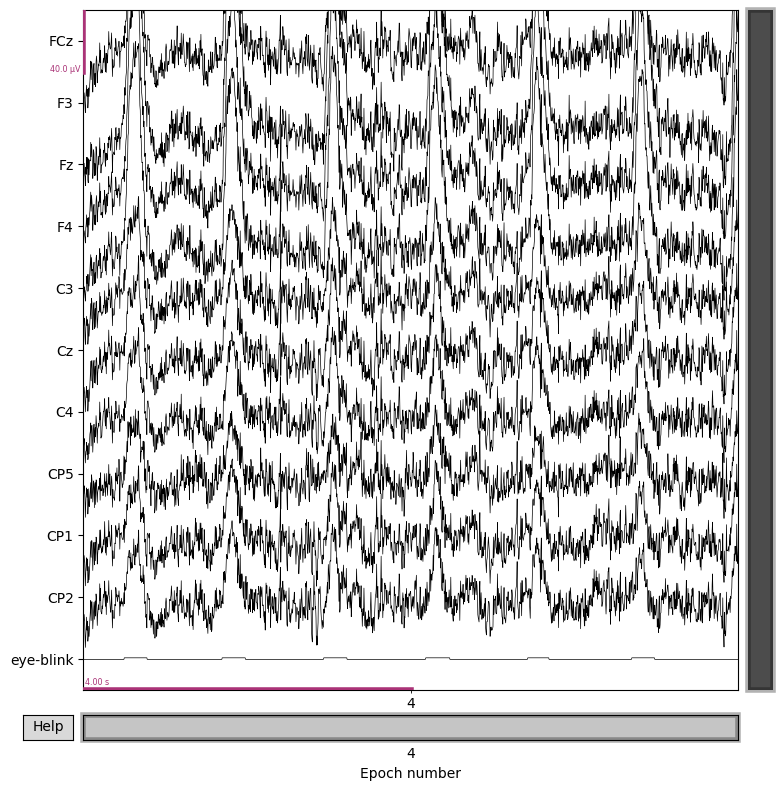

In [76]:
print(blinks_data[0].event_id)
blinks_data[0][0].plot(picks=['eye-blink', 'C3', 'C4', 'FCz', 'F3', 'Fz', 'F4', 'Cz', 'C4', 'CP5', 'CP1', 'CP2']);

## Converting EEGLABS to MNEPython
Unfortunately, our dataset is currently using the EEGLABS format. While compatible with MNEPython, EEGLABS objects are typically used in MATLAB. We will convert each object to an MNE Epochs object, which is compatible with more of MNEPython's methods, as well as NumPy.

In [77]:
print(type(blinks_data[0]))
os.makedirs("converted_epochs", exist_ok=True)

<class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>


In [78]:
def eeglabs_to_mne(eeglabs_epochs, output_folder):
    os.makedirs(f"converted_epochs/{output_folder}", exist_ok=True)
    epoch_no = 0

    for epoch in eeglabs_epochs:
        event_dict = {}
        event_list = []

        # Extract unique event names from EEGLAB
        for i, event_desc in enumerate(epoch.events[:, -1]):
            # Convert to string and assign ID
            event_label = str(epoch.event_id.get(event_desc, event_desc))
            if event_label not in event_dict:
                event_dict[event_label] = len(event_dict) + 1
            event_list.append([epoch.events[i, 0], 0, event_dict[event_label]])

        # Ensure type Int (else it crashes), and allocate new events
        event_array = np.array(event_list, dtype=int)
        epoch.events = event_array
        epoch.event_id = event_dict

        # Save converted epochs
        save_path = os.path.join(f"converted_epochs/{output_folder}", f"{epoch_no}-epo.fif")
        epoch.save(save_path, overwrite=True)
        epoch_no += 1

In [ ]:
eeglabs_to_mne(blinks_data, "blinks")
eeglabs_to_mne(h_saccades_data, "h_saccades")
eeglabs_to_mne(v_saccades_data, "v_saccades")
eeglabs_to_mne(rest_data, "rest")

The epochs objects have now been saved as .fif files, and we can read them back into memory is MNE epochs objects.

In [ ]:
converted_blinks = []
converted_h_saccades = []
converted_v_saccades = []
converted_rest = []

subfolders = {
    "blinks": converted_blinks,
    "h_saccades": converted_h_saccades,
    "v_saccades": converted_v_saccades,
    "rest": converted_rest,
}

base_path = "converted_epochs"
for subfolder, storage_list in subfolders.items():
    folder_path = os.path.join(base_path, subfolder)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".fif"):
                filepath = os.path.join(folder_path, filename)
                storage_list.append(mne.read_epochs(filepath))

In [81]:
converted_lists = [converted_blinks, converted_h_saccades, converted_v_saccades, converted_rest]

for epoch_list in converted_lists:
    print(type(epoch_list[0]))
    print(f"objects: {len(epoch_list)}")

    total_epochs = 0
    for epoch in epoch_list:
        total_epochs += len(epoch)
    print(f"total epochs: {total_epochs}\n")

<class 'mne.epochs.EpochsFIF'>
objects: 5
total epochs: 53

<class 'mne.epochs.EpochsFIF'>
objects: 5
total epochs: 54

<class 'mne.epochs.EpochsFIF'>
objects: 5
total epochs: 58

<class 'mne.epochs.EpochsFIF'>
objects: 5
total epochs: 88



## Re-epoching around trigger channels

We now have several lists of MNE Epochs objects which are ready to be used. However, each epoch still contains many events. For instance, each saccade epoch contains several saccades. To fix this, and to substantially increase the amount and quality of the training data, we can split each epoch into smaller epochs around the events which are denoted in the trigger channels.

This is necessary as, at least for the purpose of this particular model, each epoch will ultimately be averaged and the time dimension will be compressed. As such, the more specific and accurate the epochs are, the better!

In [85]:
from typing import List

def split_epochs(epochs_list: List[mne.Epochs], trigger_ch: List[str]) -> List[mne.Epochs]:
    split_epochs_list = []

    for epochs in epochs_list:
        trigger_ch_indices = [epochs.ch_names.index(ch) for ch in trigger_ch]
        sfreq = epochs.info['sfreq'] # Sampling frequency (1ms)
        data = epochs.get_data()
        new_data = []
        new_events = []

        # Time window for new epochs
        tmin_samples = int(-0.2 * sfreq)  # 200ms before
        tmax_samples = int(0.5 * sfreq)   # 500ms after
        window_length = tmax_samples - tmin_samples

        # Keep track of used time points
        used_times = set()

        for i in range(len(epochs)):
            for trigger_ch_idx in trigger_ch_indices:
                # Get trigger channel data for epoch
                trigger_data = data[i, trigger_ch_idx, :]

                # Find all timestamps where blinks start
                event_starts = np.where(np.diff(trigger_data) > 0)[0]
                for event_start in event_starts:
                    abs_time = epochs.events[i, 0] + event_start
                    # If timestamp is already used, increment until we find an unused one
                    while abs_time in used_times:
                        abs_time += 1
                    used_times.add(abs_time)

                    # Calculate window indices
                    start_idx = event_start + tmin_samples
                    end_idx = event_start + tmax_samples
                    # Check if window is within epoch bounds
                    if start_idx >= 0 and end_idx < data.shape[2]:
                        # Extract data window around blink
                        trigger_data = data[i, :, start_idx:end_idx]
                        new_data.append(trigger_data)
                        # Create an event for this blink
                        new_events.append([abs_time, 0, epochs.events[i, 2]])

        if not new_data:
            print(f"No valid events found in epoch set")
            continue

        # Convert lists to NumPy arrays
        new_data = np.array(new_data)
        new_events = np.array(new_events)
        # Sort events by time
        new_events = new_events[np.argsort(new_events[:, 0])]

        # Create new object
        new_epochs = mne.EpochsArray(
            new_data,
            epochs.info.copy(),
            new_events,
            tmin=-0.2,
            event_id={str(id): id for id in np.unique(new_events[:, 2])},
            verbose=False
        )

        split_epochs_list.append(new_epochs)

    return split_epochs_list

In [86]:
fixed_blinks = split_epochs(converted_blinks, ['eye-blink'])
fixed_v_saccades = split_epochs(converted_v_saccades, ['eye-u', 'eye-d'])
fixed_h_saccades = split_epochs(converted_h_saccades, ['eye-l', 'eye-r'])

Rest data cannot be re-epoched around the trigger channel as "resting" is not an event like "blinking" is, and as such the dataset would be very small in comparison. Instead, well cut each epoch into 0.7s chunks to match the rest of our data.

In [87]:
def split_rest_epochs(epochs_list: List[mne.Epochs]) -> List[mne.Epochs]:
    split_epochs_list = []
    for epochs in epochs_list:
        sfreq = epochs.info['sfreq']
        data = epochs.get_data()
        new_data = []
        new_events = []

        # Time window for new epochs (in samples)
        tmin_samples = int(-0.2 * sfreq)  # 200ms before
        tmax_samples = int(0.7 * sfreq)  # 700ms after
        window_length = tmax_samples - tmin_samples
        base_offset = int(epochs.events[:, 0].max()) + window_length

        for epoch_idx, epoch_data in enumerate(data):
            current_sample = 0
            epoch_length = epoch_data.shape[1]

            # Continue creating new epochs until we can't fit another window
            while current_sample + window_length <= epoch_length:
                window = epoch_data[:, current_sample:current_sample + window_length]
                new_data.append(window)
                # Create a new event with a unique time sample
                # Use base_offset plus current position to ensure uniqueness
                event_sample = base_offset + (epoch_idx * epoch_length) + current_sample
                new_event = [event_sample, 0, epochs.events[epoch_idx, 2]]
                new_events.append(new_event)
                # Move to next window
                current_sample += window_length

        # Convert lists to NumPy array
        new_data = np.array(new_data)
        new_events = np.array(new_events)

        # Create new object
        new_epochs = mne.EpochsArray(
            new_data,
            epochs.info.copy(),
            events=new_events,
            tmin=epochs.times[0],
            event_id=epochs.event_id
        )

        split_epochs_list.append(new_epochs)

    return split_epochs_list

In [ ]:
fixed_rest = split_rest_epochs(converted_rest)

Below are the new number of epochs for each event type. Roughly a 10x increase in data!

In [89]:
fixed_lists = [fixed_blinks, fixed_h_saccades, fixed_v_saccades, fixed_rest]

for fixed_list in fixed_lists:
    print(type(fixed_list[0]))
    print(f"objects (participants): {len(fixed_list)}")
    total_epochs = 0
    for epoch in fixed_list:
        total_epochs += len(epoch)
    print(f"total epochs: {total_epochs}\n")

<class 'mne.epochs.EpochsArray'>
objects (participants): 5
total epochs: 319

<class 'mne.epochs.EpochsArray'>
objects (participants): 5
total epochs: 425

<class 'mne.epochs.EpochsArray'>
objects (participants): 5
total epochs: 492

<class 'mne.epochs.EpochsArray'>
objects (participants): 5
total epochs: 704



## Data Visualisation

Here's an example of a blink epoch prior to re-epoching...

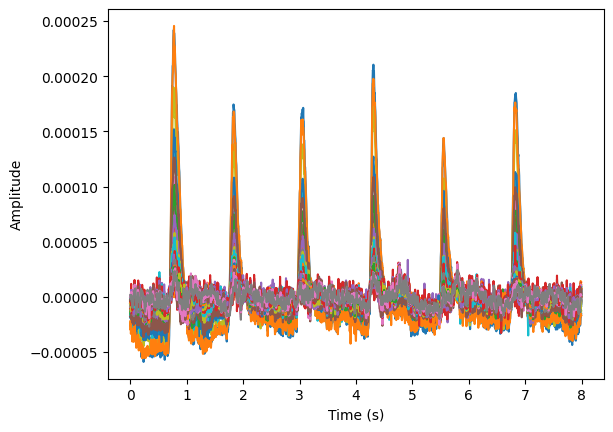

In [49]:
exclude_channels = [
    "target_X", "target_Z", "target_S", "HEOG_lpf", "VEOG_lpf", "REOG_lpf",
    "block", "eye-l", "eye-r", "eye-d", "eye-u", "eye-blink", "eye-fix",
    "eye-art", "label", "artifactclasses",
    "Fp1", "Fp2", "EOGmiddle", "EOGright", "EOGleft",
    "EOG-R-Top", "EOG-R-Side", "EOG-R-Bottom", "EOG-L-Top", "EOG-L-Side", "EOG-L-Bottom",
    "HEOG", "VEOG", "REOG", "EOGL1", "EOGL2", "EOGL3", "EOGR1", "EOGR2", "EOGR3"
]

epoch_data = converted_blinks[0].get_data()[0]  # First epoch (shape: n_channels x n_times)
times = converted_blinks[0].times

include_indices = [i for i, ch in enumerate(converted_blinks[0].ch_names) if ch not in exclude_channels]
filtered_data = epoch_data[include_indices, :]  # Exclude channels

plt.plot(times, filtered_data.T)  # Transpose for correct shape
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

And after...

58
140


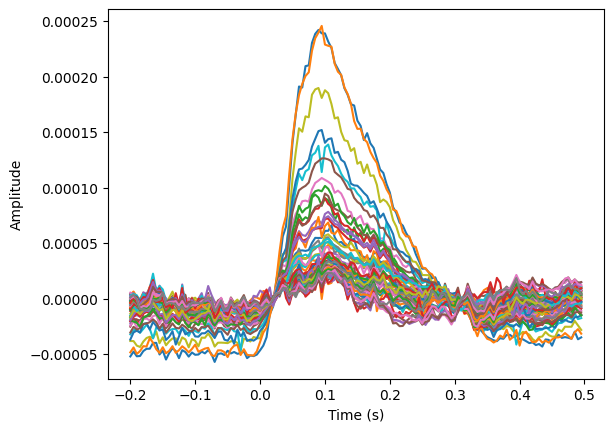

In [48]:
k = 0
while k < len(fixed_blinks):
    epoch_data = fixed_blinks[k].get_data()[0]  # First epoch (shape: n_channels x n_times)
    times = fixed_blinks[k].times

    include_indices = [i for i, ch in enumerate(fixed_blinks[0].ch_names) if ch not in exclude_channels]
    filtered_data = epoch_data[include_indices, :]  # Exclude channels

    print(len(filtered_data))
    print(len(times))

    plt.plot(times, filtered_data.T)  # Transpose for correct shape
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    k += 6

##Generating and saving topoplots

The processed data will now be used to generate topoplots, which will then be saved as .png files in their respective folders to be used for model training.

Note: When running this, set show=False, and remove the return statement!

In [92]:
def save_topoplots(split_epochs, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    img_idx = 0

    for epochs in split_epochs:
        fixed_eeg_channels = [ch for ch in epochs.info["ch_names"] if ch not in exclude_channels]  # Ensure a fixed set

        for i in range(len(epochs)):
            tmp_plot = epochs.copy().pick_channels(fixed_eeg_channels)  # Avoid modifying the original object

            # Get the data for the current epoch (shape: n_channels, n_times)
            epoch_data = tmp_plot[i].get_data().squeeze()

            # Compute the mean across time for each channel
            mean_activity = np.mean(epoch_data, axis=1)

            # Create an "Evoked" object with the averaged data (single artificial time point)
            evoked = mne.EvokedArray(mean_activity[:, np.newaxis], tmp_plot.info, tmin=0)

            # Generate the topomap plot
            fig = evoked.plot_topomap(times=0, ch_type="eeg", colorbar=False, outlines="head", show=True)

            # Save the figure as an image
            plot_filename = os.path.join(output_folder, f"{output_folder}_{img_idx}.png")
            fig.savefig(plot_filename)
            plt.close(fig)
            img_idx += 1

            print(f"Saved topomap: {plot_filename}")
            return # Temp, remove when generating files


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


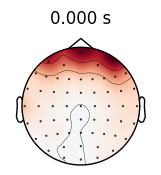

Saved topomap: img_blinks/img_blinks_0.png


In [93]:
save_topoplots(fixed_blinks, "img_blinks")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


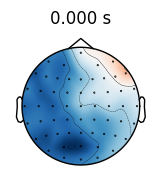

Saved topomap: img_rest/img_rest_0.png


In [94]:
save_topoplots(fixed_rest, "img_rest")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


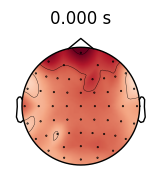

Saved topomap: img_v_saccades/img_v_saccades_0.png


In [95]:
save_topoplots(fixed_v_saccades, "img_v_saccades")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


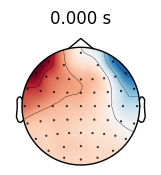

Saved topomap: img_h_saccades/img_h_saccades_0.png


In [96]:
save_topoplots(fixed_h_saccades, "img_h_saccades")

## Done!

Once you have saved the .png files to your device (if using colab), we can continue to the second notebook: model training.